In [61]:
## Libraries
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation


## Plot settings
plt.rc('xtick', direction='in', labelsize=14)
plt.rc('ytick', direction='in', labelsize=14)
plt.rc('axes', labelsize=20, titlesize=22)
plt.rc('legend', fontsize=14)
plt.rc('animation', html='jshtml')
plt.rcParams['font.family'] = 'DeJavu Serif'
plt.rcParams['font.serif'] = ['Computer Modern Roman']
plt.rcParams['mathtext.fontset'] = 'cm'

In [62]:
## Read coordinates and indices

grid_coordinates = []
with open('../../../../../Grids/AB_grid.txt', 'r') as reader:
    line = reader.readline()

    while line != '':
        elements = line.split(',')
        point = (float(elements[0]),float(elements[1]))
        grid_coordinates.append(point)
        line = reader.readline()

jump_coordinates = []
with open('../../../../../Grids/AB_jump_coordinates.txt', 'r') as reader:
    line = reader.readline()

    while line != '':
        elements = line.split(' ')
        data_block = []
        for ele in elements:
            temp = ele.replace('(', '').replace(')', '')
            if temp != 'stop':
                x = temp.split(',')[0]
                y = temp.split(',')[1]
                point = (float(x),float(y))
                data_block.append(point)
            else:
                break
        line = reader.readline()
        jump_coordinates.append(data_block)

jump_indices = []
with open('../../../../../Grids/AB_jump_indices.txt', 'r') as reader:
    line = reader.readline()

    while line != '':
        elements = line.split(' ')
        data_block = []
        for ele in elements:
            if ele != 'stop':
                data_block.append(int(ele))
            else:
                break
        line = reader.readline()
        jump_indices.append(data_block)

# For drawing vertices use grid_coordinates
# For drawing lines use jump_coordinates
# For indices use jump_indices

## We now want to scale down the plot so it will fit inside a unit square in the 1st quadrant

# Compare x and y components seperatly to for the maximal distances along each axis
xs = [x for x,y in grid_coordinates]
ys = [y for x,y in grid_coordinates]

xs_length = abs(max(xs)) + abs(min(xs))
ys_length = abs(max(ys)) + abs(min(ys))

# We can now scale all xs and ys to fit inside a unit square
xs_scaled = [i/xs_length for i in xs]
ys_scaled = [i/ys_length for i in ys]
grid_scaled = [(x,y) for x, y in zip(xs_scaled, ys_scaled)]

# Same thing for all jump coodinates
jump_scaled = []
for i in jump_coordinates:
    xs_temp = [j[0]/xs_length for j in i]
    ys_temp = [j[1]/ys_length for j in i]
    jump_temp = [(x,y) for x, y in zip(xs_temp, ys_temp)]
    jump_scaled.append(jump_temp)


# The new vertices are stored in grid_scaled
# The new jumps are stored in jump_scaled

# Time evolution by giving index of states
def time_evolve_evec(group_of_states, coefficients, time, evec, eval):

    hbar = 1
    t = time

    # Make the group of states in to vectors and multiply with time op
    phis = [c*np.exp(-1j*(eval[i]/hbar)*t)*evec[i] for i, c in zip(group_of_states, coefficients)]

    # Make a linear combination equally divided
    a = len(phis)
    psi = sum([x for x in phis])

    phi_norm = psi / (np.sqrt(np.vdot(psi,psi)))

    density_of_states = [(x.conj() * x).real for x in phi_norm]
    
    return phi_norm, density_of_states


In [63]:
# Hamiltonian cell
# The pure Hamiltonian
def Hamil_solve(z, w, B):
    # Define now a skeleton of the Hamiltonian 
    dim_H = len(z)
    H = np.zeros((dim_H, dim_H), dtype= np.complex128)
    k_H = [x for x in range(0, dim_H)]
    # Calculate Peierls phase factor according to the 1st artcle 
    
    # Start by finding the tile length
    tile_lens = [np.linalg.norm(np.array(z[0]) - np.array(x)) for x in w[0]]
    tile_lens_sum = np.sum(tile_lens)
    l  = tile_lens_sum/len(tile_lens)
    phi = B * l**2
    phi_0 = 2 * np.pi
    jump_products = []
    for i, j in zip(z, w):
        products = [(i[0]*k[1] - k[0]*i[1]) for k in j]
        jump_products.append(products)
    phase_factors = []
    for i, j in zip(z, jump_products):
        phases = [-(phi/(2 * l**2)) * k for k in j]
        phase_factors.append(phases)

    # Scaling via J, maybe energy factor
    J = 1
    # Fill out the Hamiltonian according to the psi vector, i.e. the basis chosen through generation of the tiling
    for x, y, z in zip(k_H, jump_indices, phase_factors):
        for k, t in zip(y, z):
            H[x, k] = -J * np.exp(1j * t)

    # Now we find the eigenvalues and eigenvectors
    # Note that eigh returns normalized eigenvectors!
    # Note the eigenvectors are arranged in a matrix so eig_vecs[:,i] chooses the i'th column which is the i'th eigenvector
    eig_vals, U = np.linalg.eigh(H)
    eig_vecs = np.array([U[:,i] for i in range(len(U))])
    return eig_vals, eig_vecs, H

B_full = (2*np.pi)/(0.03825242185233838**2)
B_scale = 0.55

evals, evecs, H = Hamil_solve(grid_scaled, jump_scaled, (B_scale)*B_full)

In [64]:
# Rotation cell
def rotation(phi):
    operator = np.array([[np.cos(phi), -np.sin(phi)],[np.sin(phi), np.cos(phi)]])
    return operator

def translation(vector, coordinate):
    operator = vector + np.array([coordinate[0], coordinate[1]])
    return operator

def argz(z):
    a = np.angle(z)
    if a >= 0:
        return a
    else:
        return 2*np.pi + a

# This takes a vector from the basis of lattice sites and rotates it n-fold and assigns to a new vector in the same
def rot_op(site, n):
    # Site is a vector describing the coordinate of a supposed occupied site, which we want rotate (1/n)-fold
    # Rads tells the operator how much we should rotate
    rads = (2*np.pi)/(n)
    
    # Rotate site
    rot_site = np.matmul(rotation(rads), np.array(site))
    
    # We aim to assign the rotated site to an already exisiting coordiante pair, so we will compare with grid_scaled
    
    # Find sites close enough
    grain2 = -5
    close_by_ele = [(ele, count) for count, ele in enumerate(np.array(grid_scaled)) if -10**(grain2) <= np.linalg.norm(rot_site - np.array(ele)) <= 10**(grain2)]
    if len(close_by_ele) > 1 or len(close_by_ele) == 0:
        print(f'close_by_eles has a length of {len(close_by_ele)}')
        return
    else:
        # This more than likely only returns one element
        # This element comes with an index which we use to assign the rotated site to the preexisting coordinates
        new_site = grid_scaled[close_by_ele[0][1]]
        new_x = new_site[0]
        new_y = new_site[1]
        ns_index = close_by_ele[0][1]
        return (new_x, new_y), ns_index
    

# We now use the above function to construct an explicit rotation operator by applying and extracting the index for every basis element
dim = len(grid_scaled)
R = np.zeros((dim,dim),dtype= np.complex128)
indices = []
new_coordinates = []
for w in range(dim):
    coor, rot_index = rot_op(grid_scaled[w], 8)
    indices.append(rot_index)
    new_coordinates.append(coor)

complex_coor = [complex(*x) for x in grid_scaled]
complex_coor_rot = [complex(*x) for x in new_coordinates]
# With the new coordinates of each transformed coordinate we may determine the phase between 
#phases = [y/x for x, y in zip(complex_coor, complex_coor_rot)]
#theta = [arg(z) for z in phases]

for i, j in zip(range(dim), indices):
    # Note the order is to make sure in the picture of a matrix being made of column vectors, that we get the right non-zero entries
    # If we flip the order we get the transpose. Reason being that np intreprets entries along every row constituting the matrix in stead
    R[j][i] = 1

In [79]:
r_evals, r_U = np.linalg.eigh(R)
r_evecs = np.array([r_U[:,i] for i in range(len(r_U))])

h_evals, h_evecs, H = Hamil_solve(grid_scaled, jump_scaled, (B_scale)*B_full)

# Now check the unique eigenvalues in the list

def unique(list):
    unique_list = []
    for x in list:
        if len([y for y in unique_list if abs(x-y) < 10**(-2)]) == 0:
            unique_list.append(x)
        if x in unique_list:
            pass
    return unique_list

unique_r_evals = unique(r_evals)
unique_r_evals

def check_degeneracy(eval, grain):
    deg_ener = []
    for count, ele in enumerate(eval):
        evals_list = list(eval)
        eles = [(z,index) for index, z in enumerate(eval) if abs(ele - z) < 10**(-grain) and evals_list.index(z) != count]
        if len(eles) > 0:
            deg_ener.append(count)
        else:
            pass
    if len(deg_ener) == 0:
        return print(f'No degeneracies were found with grain= 10**(-{grain})')
    else:
        print(f'Degeneracies were found with grain= 10**(-{grain})')
        return deg_ener

Degeneracies were found with grain= 10**(-4)


[33, 34, 181, 182, 328, 329, 342, 343, 345, 346, 359, 360, 506, 507, 654, 655]

In [81]:
# We have diagonalised R
r_diag = np.diag(r_evals)

# We should write H in this basis

In [82]:
r_diag

array([[-1.73205081,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        , -1.73205081,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        , -1.73205081, ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  1.73205081,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         1.73205081,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  1.73205081]])

0j
(0.002180874065095961+0j)


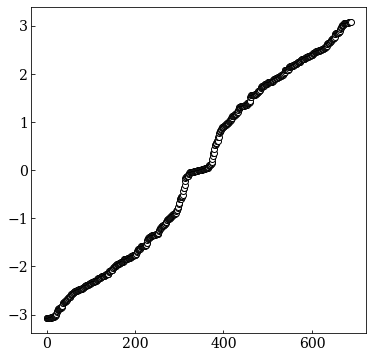

In [77]:
fig, ax = plt.subplots(figsize= (6,6))

xs = range(len(h_evals))
ax.scatter(xs, h_evals, facecolor= 'w', edgecolor= 'k')

plt.show()